# David Centeno Pedrido - R, XGBoost, Exploratory Data Analysis

We are going to make a prediction model to be able to estimate if Kobe Bryant's basket shots are going to hit or miss. To do this we will use a set of data that has diverse information about how more than 30,000 shots were made during the Kobe's career. 

This project is inspired by [Kaggle competition](https://www.kaggle.com/c/kobe-bryant-shot-selection). In the link, there is access to the data we will use in this project.

We start loading the libreries and the data:

In [2]:
library(ggplot2)
library(dplyr)
library(gridExtra)
library(hexbin)
library(caret)
library(stringr)
options(warn=-1)

data <- read.csv('../data.csv')

First of all we will perform an extensive analysis on the dataset we will use for the project. Taking a first look at it we can find this variables:

In [2]:
str(data)

'data.frame':	30697 obs. of  25 variables:
 $ action_type       : Factor w/ 57 levels "Alley Oop Dunk Shot",..: 27 27 27 27 6 27 28 27 27 42 ...
 $ combined_shot_type: Factor w/ 6 levels "Bank Shot","Dunk",..: 4 4 4 4 2 4 5 4 4 4 ...
 $ game_event_id     : int  10 12 35 43 155 244 251 254 265 294 ...
 $ game_id           : int  20000012 20000012 20000012 20000012 20000012 20000012 20000012 20000012 20000012 20000012 ...
 $ lat               : num  34 34 33.9 33.9 34 ...
 $ loc_x             : int  167 -157 -101 138 0 -145 0 1 -65 -33 ...
 $ loc_y             : int  72 0 135 175 0 -11 0 28 108 125 ...
 $ lon               : num  -118 -118 -118 -118 -118 ...
 $ minutes_remaining : int  10 10 7 6 6 9 8 8 6 3 ...
 $ period            : int  1 1 1 1 2 3 3 3 3 3 ...
 $ playoffs          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ season            : Factor w/ 20 levels "1996-97","1997-98",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ seconds_remaining : int  27 22 45 52 19 32 52 5 12 36 ...
 $ shot_distance     : in

We have 25 numerical and discrete variables, the titles of each column are self-explanatory. Quickly we realize that there are a series of variables that are only used as identifiers and that are not going to provide us with information at the time of building a prediction model, these are:
- game_event_id.
- game_id.
- team_id.
- team_name. Variable that refers to the scoring team. In this dataset it is always the same, Kobe Bryant's team: Los Angeles Lakers.
- game_date. This variable was discarded because the dataset already had others that could provide more information for the context of the game and the shots as season, period, minutes_remaining, seconds_remaining, etc.
- shot_id.

The variable we are going to predict is shot_made_flag. It's a discrete binary variable with two possible values, 0 in case the shot was missed and 1 in case it was hit, so we face a binary classification problem.
We are going to look for those values that can be missing in the dataset, and decide what strategy to follow according to which fields have missing data and how many dataset rows have this problem, we will look for by column what number of missing elements we have:

In [3]:
colSums(is.na(data))

action_type combined_shot_type      game_event_id            game_id 
                 0                  0                  0                  0 
               lat              loc_x              loc_y                lon 
                 0                  0                  0                  0 
 minutes_remaining             period           playoffs             season 
                 0                  0                  0                  0 
 seconds_remaining      shot_distance     shot_made_flag          shot_type 
                 0                  0               5000                  0 
    shot_zone_area    shot_zone_basic    shot_zone_range            team_id 
                 0                  0                  0                  0 
         team_name          game_date            matchup           opponent 
                 0                  0                  0                  0 
           shot_id 
                 0

The only field with missing values is shot_made_flag. This is the variable on which we want to make the prediction, and also these cases where the data does not exist are those that are evaluated within the competition, so we will eliminate them so as not to take them into account in the training and use the rest of the data.

And now, we will take a look over the data.

## shot_distance

It's easy to find out that the distance as well as the position can be an element to keep in mind at the time of making a model of this type, in this way the first variable that can make sense to analyze is the distance. It is expected that both the percentage of hits as the number of shots decrease as the distance increases, understanding also that it will be an important variable in the prediction.

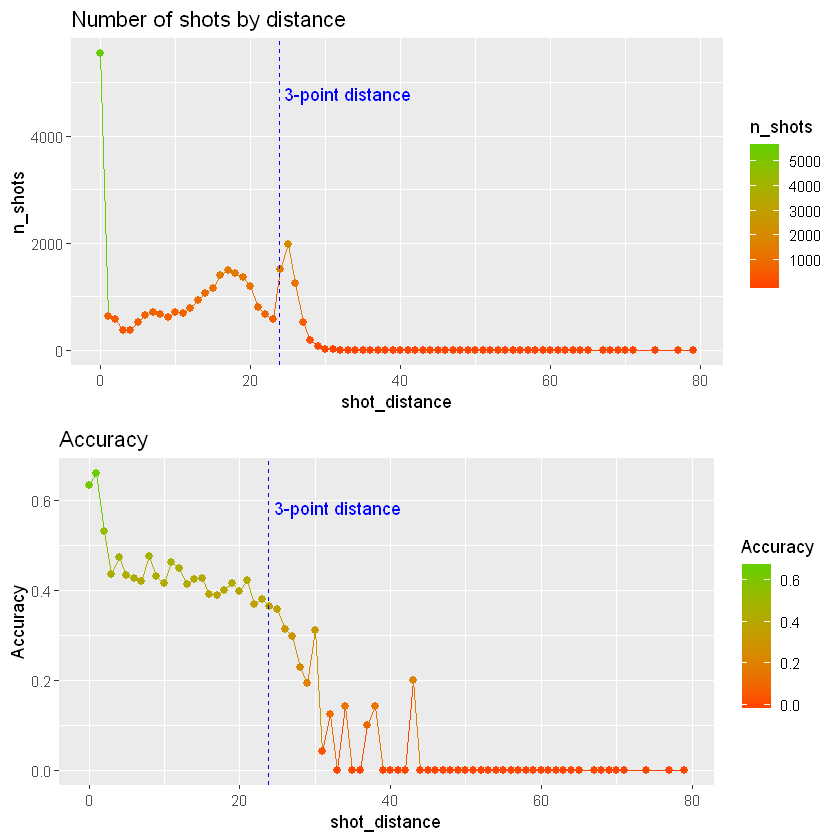

In [3]:
acc_by_distance <- data %>%
  group_by(shot_distance) %>%
  summarise(Accuracy=mean(shot_made_flag, na.rm=TRUE), n_shots = n()) 

p1 <- ggplot(acc_by_distance, aes(x=shot_distance, y=n_shots)) + 
  geom_line(aes(colour=n_shots)) +
  geom_point(aes(colour=n_shots), size=2) +
  scale_colour_gradient(low="orangered", high="chartreuse3") +
  geom_vline(xintercept = 7.24*3.2808,linetype="dashed",col="blue", size=0.5) +
  annotate("text", x = 33, y = 4500, 
           label = 'atop("3-point distance")',
           colour = "blue", parse = TRUE) +
  ggtitle('Number of shots by distance')

p2 <- ggplot(acc_by_distance, aes(x=shot_distance, y=Accuracy)) + 
  geom_line(aes(colour=Accuracy)) +
  geom_point(aes(colour=Accuracy), size=2) +
  scale_colour_gradient(low="orangered", high="chartreuse3") +
  geom_vline(xintercept = 7.24*3.2808,linetype="dashed",col="blue", size=0.5) +
  annotate("text", x = 33, y = 0.55, 
           label = 'atop("3-point distance")',
           colour = "blue", parse = TRUE)+
  ggtitle('Accuracy')

grid.arrange(p1, p2, ncol=1)

We see that both decreasing tendencies are fulfilled in general, but with an increase of the shots in the 3-point zone, which makes sense since the three zone is a very usual zone to shoot being a skilled shooter. We can also see that there is no difference between the shots from 40ft distance, so we will put a value of 45 on the highest ones.

## Shooting position: shot zone basic

We will try to give more context to the positions from which the shots have been taken by analyzing shot_zone_area, shot_zone_basic and shot_zone_range that divide the field into different zones. We proceed to analyze the hits and the number of shots from each of them. 

We starting with shot_zone_basic:

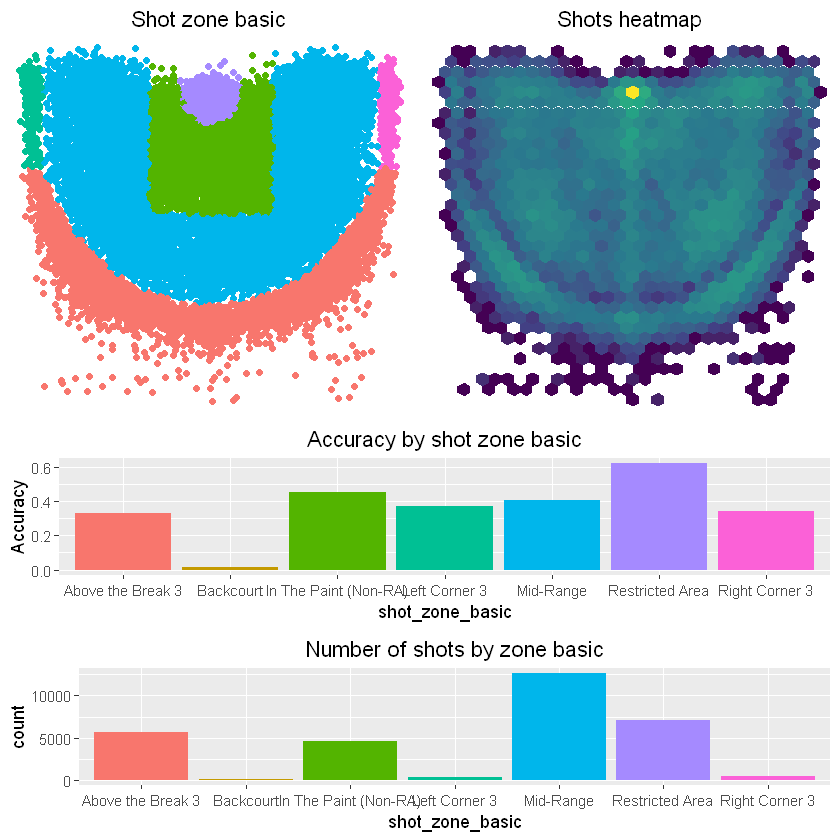

In [4]:
freq_by_shot_zone_basic <- data %>%
  group_by(shot_zone_basic) %>%
  summarise(Accuracy=mean(shot_made_flag, na.rm=TRUE), n_shots = n()) 

p3 <- ggplot(data, aes(x=lon, y=lat)) +
  geom_point(aes(color=shot_zone_basic)) +
  labs(title="Shot zone basic") +
  ylim(c(33.7, 34.0883)) +
  theme_void() +
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))

p4 <- ggplot(data, aes(x=lon, y=lat) ) +
  geom_hex(show.legend = FALSE) +
  labs(title="Shots heatmap") +
  ylim(c(33.7, 34.0883)) +
  #theme_bw() + 
  scale_fill_viridis_c(trans = "log") +
  theme_void() +
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))

acc_by_shot_zone_basic <- data %>%
  group_by(shot_zone_basic) %>%
  summarise(Accuracy=mean(shot_made_flag, na.rm=TRUE), n_shots = n()) 

p5 <- ggplot(acc_by_shot_zone_basic, aes(x=shot_zone_basic, y=Accuracy))+
  geom_col(aes(fill=shot_zone_basic),show.legend = FALSE) +
  labs(title="Accuracy by shot zone basic") +
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))

p6 <- ggplot(data, aes(shot_zone_basic))+
  geom_bar(aes(fill=shot_zone_basic),show.legend = FALSE)+
  labs(title="Number of shots by zone basic")+
  theme(legend.position="none",
      plot.title=element_text(hjust=0.5))

grid.arrange(p3,p4,p5,p6,layout_matrix = rbind(c(1,2),c(1,2),c(3,3),c(4,4)))

In the graph on the upper left, we see the shots made by Kobe for each of the shooting zones marked in the shot_zone_basic field, you can see that we have 7 well differentiated zones that correspond to each of the values that the variable can have. In the upper right zone we see a heat map on the distribution of the shots, although it is true that we have an important focus just below the basket, we can see that the distribution of the shots on both sides of the field (left / right) is stable since the graph is symmetrical.

Below we have two graphs that show the percentage of success for each of the types of shots and the number of shots per area. It's easy to see that the two zones from where he has shot more have been the mid-range distance (marked in blue) and the nearest zone to the basket (marked in purple), being this last one also the one with the best percentage of success among all. This was something that we could also know with the graph where we presented the percentage of success according to distance.


## Shooting position: shot zone area and shot zone range

We do the same analysis, but using the other two variables related to the shot zone, we continue with shot zone area:

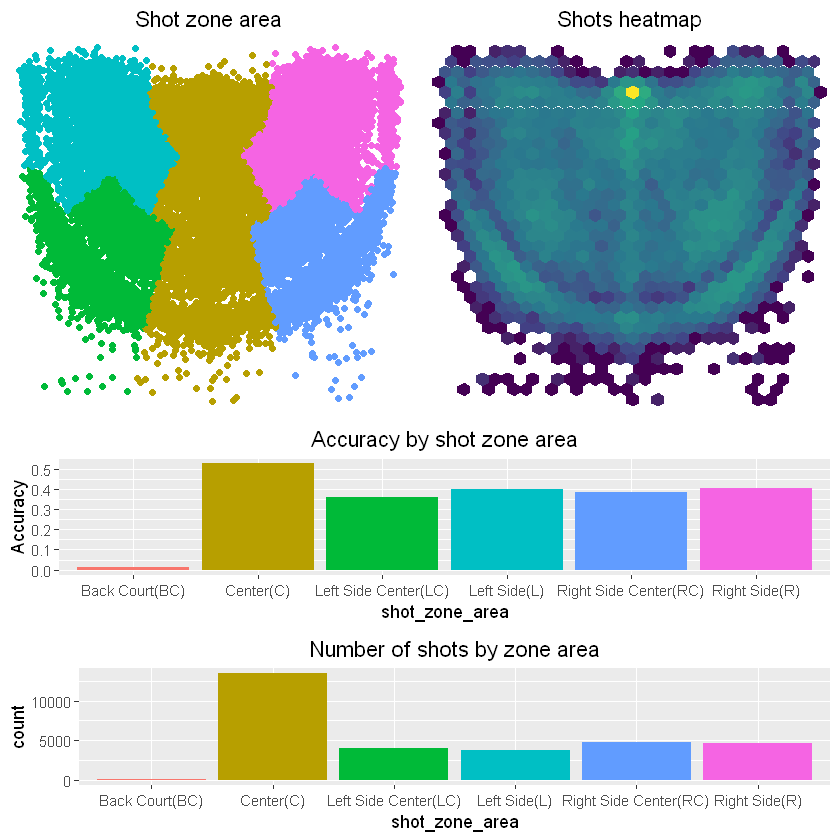

In [5]:
# shot zone area
freq_by_shot_zone_area <- data %>%
  group_by(shot_zone_area) %>%
  summarise(Accuracy=mean(shot_made_flag, na.rm=TRUE), n_shots = n()) 

p7 <- ggplot(data, aes(x=lon, y=lat)) +
  geom_point(aes(color=shot_zone_area)) +
  labs(title="Shot zone area") +
  ylim(c(33.7, 34.0883)) +
  theme_void() +
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))

acc_by_shot_zone_area <- data %>%
  group_by(shot_zone_area) %>%
  summarise(Accuracy=mean(shot_made_flag, na.rm=TRUE), n_shots = n()) 

p8 <- ggplot(acc_by_shot_zone_area, aes(x=shot_zone_area, y=Accuracy))+
  geom_col(aes(fill=shot_zone_area),show.legend = FALSE) +
  labs(title="Accuracy by shot zone area") +
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))

p9 <- ggplot(data, aes(shot_zone_area))+
  geom_bar(aes(fill=shot_zone_area),show.legend = FALSE)+
  labs(title="Number of shots by zone area")+
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))

grid.arrange(p7, p4, p8, p9,layout_matrix = rbind(c(1,2),c(1,2),c(3,3),c(4,4)))


And shot zone range:

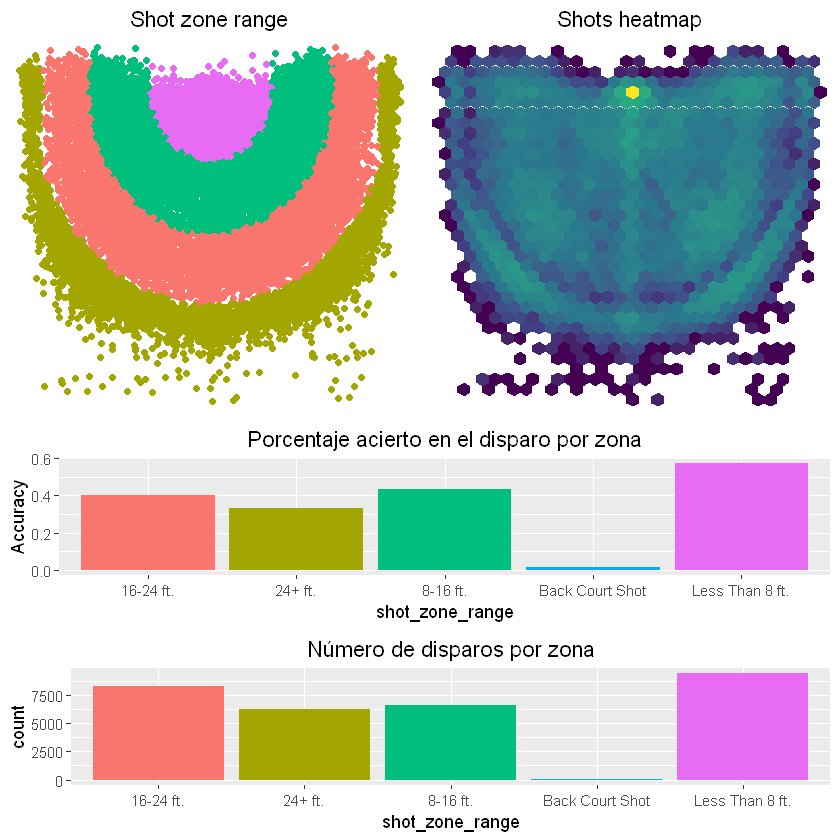

In [6]:
# shot zone range

freq_by_shot_zone_range <- data %>%
  group_by(shot_zone_range) %>%
  summarise(Accuracy=mean(shot_made_flag, na.rm=TRUE), n_shots = n()) 

p10 <- ggplot(data, aes(x=lon, y=lat)) +
  geom_point(aes(color=shot_zone_range)) +
  labs(title="Shot zone range") +
  ylim(c(33.7, 34.0883)) +
  theme_void() +
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))

acc_by_shot_zone_range <- data %>%
  group_by(shot_zone_range) %>%
  summarise(Accuracy=mean(shot_made_flag, na.rm=TRUE), n_shots = n()) 

p11 <- ggplot(acc_by_shot_zone_range, aes(x=shot_zone_range, y=Accuracy))+
  geom_col(aes(fill=shot_zone_range),show.legend = FALSE) +
  labs(title="Porcentaje acierto en el disparo por zona") +
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))

p12 <- ggplot(data, aes(shot_zone_range))+
  geom_bar(aes(fill=shot_zone_range),show.legend = FALSE)+
  labs(title="Número de disparos por zona")+
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))

grid.arrange(p10, p4, p11,p12,layout_matrix = rbind(c(1,2),c(1,2),c(3,3),c(4,4)))

It has also been detected that there are two pairs of variables that are very closely related and provide the same information: lat and lon contain information about the position of the point as do loc_x and loc_y, so we will stop using them during the analysis.

## Time remaining

Remaining quarter time: Let's see if the remaining time of the quarter also impacts on the success of Kobe's shots, in this case we have two fields, minutes_remaining and seconds_remaining, which identify the minutes and seconds remaining in the quarter, respectively. To see if the percentage of success changes we will use the minutes:

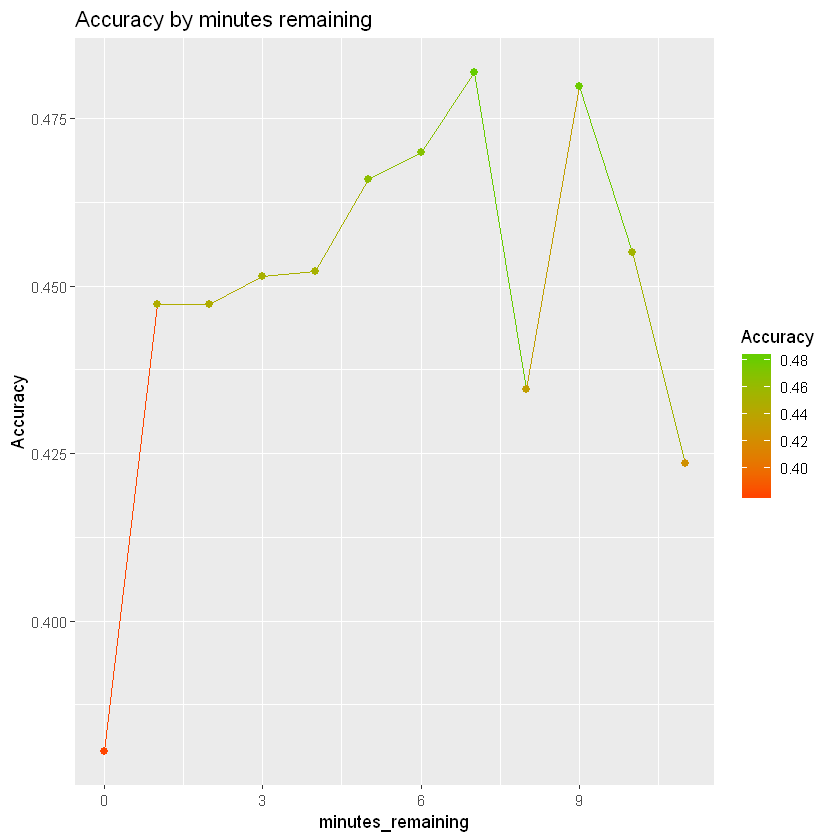

In [7]:
minutes_remaining <- data %>%
  group_by(minutes_remaining) %>%
  summarise(Accuracy = mean(shot_made_flag, na.rm=TRUE), n_shots = n())

ggplot(minutes_remaining, aes(x=minutes_remaining, y=Accuracy)) + 
  geom_line(aes(colour=Accuracy)) +
  geom_point(aes(colour=Accuracy), size=2) +
  scale_colour_gradient(low="orangered", high="chartreuse3") +
  ggtitle("Accuracy by minutes remaining")

It is clear that the moment of the match affects the percentage of Kobe's success, so we will generate some fields from these two variables (minutes and seconds) that will allow us to be able to detect this effect better, so we will identify when it is in the last 3 minutes of the quarter and also when it is in the last 3 seconds of the quarter, since the shots we make at these times are usually more forced. 

These two variables are going to be categorical. We will also generate a field that has in seconds the time remaining in the quarter, thus bringing together the information contained in seconds_remaining and minutes_remaining.

## Home / away games

Matchup: This field will allow us to identify if the match has been played away from home or as a home game, which usually affects the player's performance. We are going to analyze in two boxplots if there can be differences in the distribution in the percentage of success according to whether it is played at home or away:

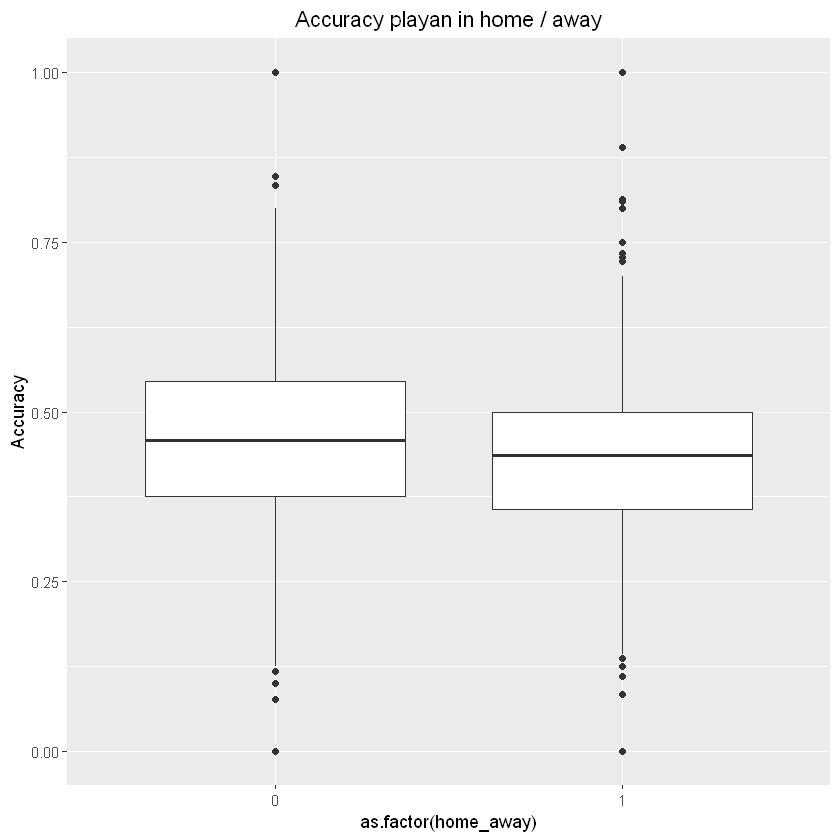

In [8]:
data_local_match <- data
data_local_match$home_away <- ifelse(grepl('@', data_local_match$matchup, fixed = TRUE), 1, 0)

data_local_match <- data_local_match %>%
  group_by(game_id, home_away) %>%
  summarise(Accuracy = mean(shot_made_flag, na.rm=TRUE), n_shots = n())

ggplot(data_local_match, aes(x=as.factor(home_away), y=Accuracy)) +
  geom_boxplot()+
  labs(title="Accuracy playan in home / away")+
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))

It seems that, as we expected, the percentage tends to be a little worse when playing away from home, so this variable can be helpful in our goal. We will therefore generate a categorical variable that differentiates both situations.

## Action and shot type

They are going to provide us with information about the situation in which Kobe shot: shot from the air, dunk... We are going to investigate these variables a little more:

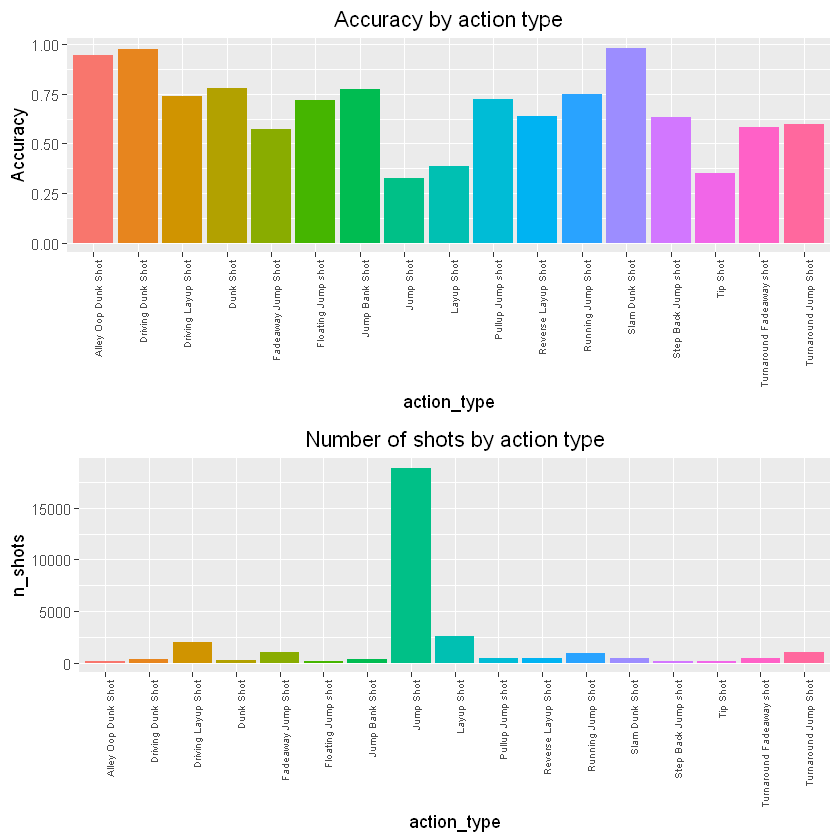

In [9]:
# action type

action_type <- data %>%
  group_by(action_type) %>%
  summarise(Accuracy = mean(shot_made_flag, na.rm=TRUE), n_shots = n())

action_type <- action_type[action_type$n_shots > 100,]

action_type_p1 <- ggplot(action_type, aes(x=action_type, y=Accuracy))+
  geom_col(aes(fill=action_type),show.legend = FALSE) +
  labs(title="Accuracy by action type") +
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 6))

action_type_p2 <- ggplot(action_type, aes(x=action_type, y=n_shots))+
  geom_col(aes(fill=action_type),show.legend = FALSE) +
  labs(title="Number of shots by action type") +
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 6))

grid.arrange(action_type_p1, action_type_p2)


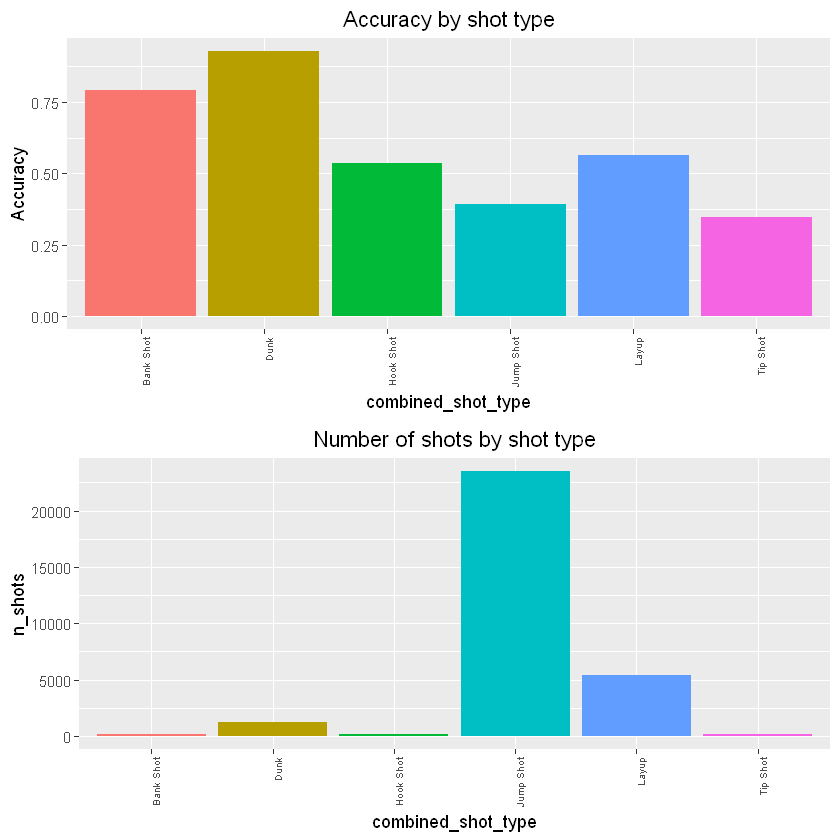

In [10]:
# combined shot type

combined_shot_type <- data %>%
  group_by(combined_shot_type) %>%
  summarise(Accuracy = mean(shot_made_flag, na.rm=TRUE), n_shots = n())

combined_shot_type_p1 <- ggplot(combined_shot_type, aes(x=combined_shot_type, y=Accuracy))+
  geom_col(aes(fill=combined_shot_type),show.legend = FALSE) +
  labs(title="Accuracy by shot type") +
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 6))

combined_shot_type_p2 <- ggplot(combined_shot_type, aes(x=combined_shot_type, y=n_shots))+
  geom_col(aes(fill=combined_shot_type),show.legend = FALSE) +
  labs(title="Number of shots by shot type") +
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 6))

grid.arrange(combined_shot_type_p1, combined_shot_type_p2)


To be able to visualize well we have only taken into account those types of action that have had more than 100 occurrences. It is evident that the success of a Kobe shot depends strongly on these variables.

## Regular season / playoff

We are going to analyze if there is any difference in Kobe's success percentage during the regular season vs. during the playoff, for that we are going to draw a histogram with the percentage in both moments:

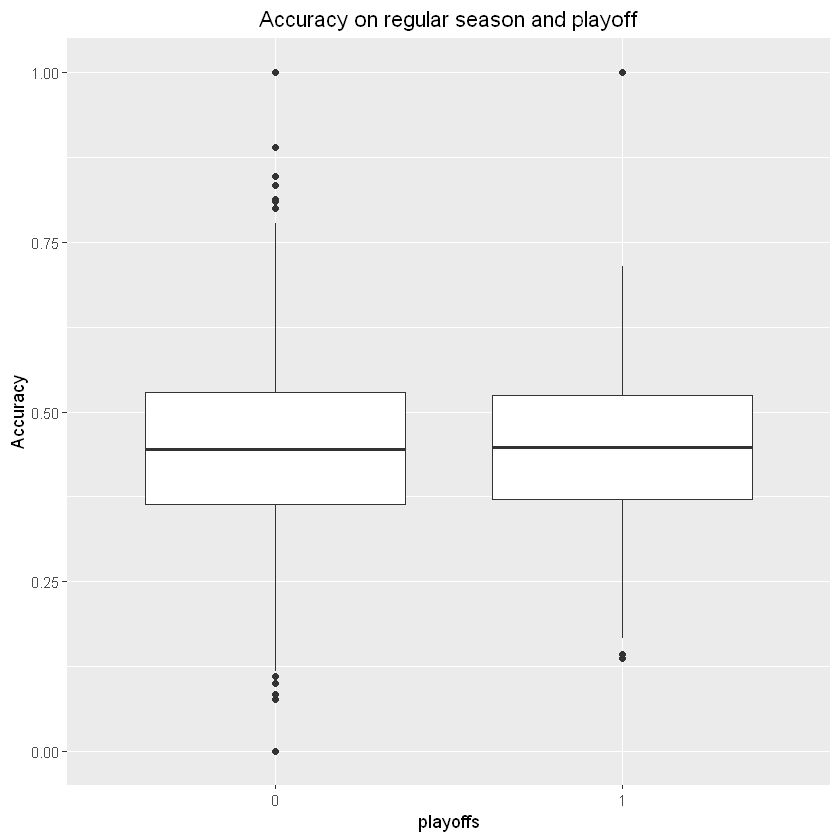

In [11]:
playoff_season <- data %>%
  group_by(game_id, playoffs) %>%
  summarise(Accuracy = mean(shot_made_flag, na.rm=TRUE), n_shots = n())
playoff_season['playoffs'] <- as.factor(playoff_season$playoffs)

ggplot(playoff_season, aes(x=playoffs, y=Accuracy)) +
  geom_boxplot()+
  labs(title="Accuracy on regular season and playoff")+
  theme(legend.position="none",
        plot.title=element_text(hjust=0.5))

There is not much variation in player performance between the two situations. By the way, we can perform a __Kolmogorov-Smirnoff__ test to check it!

In [12]:
reg_accuracy = playoff_season[playoff_season$playoffs == 0,]$Accuracy
playoff_accuracy = playoff_season[playoff_season$playoffs == 1,]$Accuracy

ks.test(reg_accuracy, playoff_accuracy)


	Two-sample Kolmogorov-Smirnov test

data:  reg_accuracy and playoff_accuracy
D = 0.052177, p-value = 0.687
alternative hypothesis: two-sided


Here, we have a p-value 0.687, so we cannot claim statistical support for a difference between distributions, like we thought at looking both boxplots.

# Data processing

According to everything discovered in the exploratory analysis, we are going to carry out the different appropriate data transformations:

In [18]:
# tratamiento de datos
data_clean <- data
data_clean[c('game_id', 'game_event_id', 'lat', 'lon', 'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id')] <- NULL
data_clean['time_remaining'] <- data_clean$minutes_remaining * 60 + data_clean$seconds_remaining
data_clean[c('minutes_remaining', 'seconds_remaining')] <- NULL
data_clean$shot_distance[data_clean$shot_distance>40] <- 40
data_clean$season <- sapply(data_clean$season, function(x){str_extract(x, "(?<=[:punct:])[:digit:]{2}")})
data_clean$lastminutes <- ifelse(data_clean$time_remaining <= 180, 1, 0)
data_clean$lastseconds <- ifelse(data_clean$time_remaining <= 5, 1, 0)
data_clean$home_away <- ifelse(grepl('@', data$matchup, fixed = TRUE), 1, 0)

# agregating minor action_types:
action_type_minor <- data_clean %>%
  group_by(action_type) %>%
  summarise(n = n())
action_type_minor = action_type_minor[order(action_type_minor$n, decreasing = TRUE),]
cols <- action_type_minor[action_type_minor$n<50,'action_type'] # happened less than 50 times

dmy <- dummyVars(" ~ .", data = data_clean) # dummy variable from categorical fields
data_clean <- data.frame(predict(dmy, newdata = data_clean))

columns_delete <- paste("action_type.", cols$action_type, sep = '')
columns_delete <- gsub(' ', '.', columns_delete)
columns_delete <- gsub('-', '.', columns_delete)
data_clean['other_action_type'] <- rowSums(data_clean[columns_delete]) # adding all of them in "others" group
data_clean[columns_delete] <- NULL # removing all action types happened less than 50 times

data_suibmission <- data_clean[is.na(data_clean$shot_made_flag),]
data_clean <- na.omit(data_clean)
data_clean['shot_made_flag'] <- as.factor(data_clean$shot_made_flag)
data_clean$shot_made_flag <- ifelse(data_clean$shot_made_flag == 0, "miss", "made")


# Model

For our case, we are going to focus on choosing a model and comparing different combinations of hyperparameters in order to choose the best combination, rather than focusing on comparing different models. 

In this work we will use the eXtreme Gradient Boosting model included in the list of caret models, it is a variant of the decision trees that is generating very good results in several classification or regression problems. 

We will make a grid on different parameters of the model, which will allow us to try different combinations and thus choose the one that best solves our problem. During the training we will use a cross-validation variant that is included in the library, called repeated-cv that is simply a usual cv but repeats the process n times.

We are not going to divide into train and test, since we seek to exploit all the information we can get from the set we have been given and the real validation of the model will be done through Kaggle, where for every prediction we make about the 5,000 shots missing from the dataset we will calculate the logloss and give us a score based on the value. And, as this metric will be the one that puts us in a competition position in the competition, it will be the one that we will use as a metric to evaluate in the training.

With all this, we start with the grid and get these results from the best 10 trainings:

In [19]:
set.seed(1)
trctrl <- trainControl(method = "repeatedcv", number = 5, repeats = 5, summaryFunction=mnLogLoss, classProbs = TRUE)

tune_grid <- expand.grid(nrounds = c(200),
                         max_depth = c(5),
                         eta = c(0.038, 0.035, 0.025),
                         gamma = 0.001,
                         colsample_bytree = 0.8,
                         min_child_weight = 0,
                         subsample = c(0.7, 0.8))

grid_fit <- train(shot_made_flag ~., data = data_clean, method = "xgbTree", metric = 'logLoss', maximize=FALSE,
                trControl=trctrl,
                tuneGrid = tune_grid,
                tuneLength = 10)

In [21]:
results_training_grid = grid_fit$results
results_training_grid <- results_training_grid[order(results_training_grid$logLoss),]
head(results_training_grid, 5)

pred <- predict(grid_fit, data_clean)
confusionMatrix(as.factor(data_clean$shot_made_flag), pred)

test <- data[is.na(data$shot_made_flag),]$shot_id
pred <- predict(grid_fit, data_suibmission, type='prob')
samples <- data.frame(shot_id = test, shot_made_flag = pred$made)
# write.csv(samples, file = "../sample_submission_kaggle/submission1.csv", row.names = F, quote=FALSE)

,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,logLoss,logLossSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,0.038,5,0.001,0.8,0,0.7,200,0.6026533,0.005544531
3,0.035,5,0.001,0.8,0,0.7,200,0.6026965,0.005554114
6,0.038,5,0.001,0.8,0,0.8,200,0.6027073,0.005631738
4,0.035,5,0.001,0.8,0,0.8,200,0.6027632,0.005563288
2,0.025,5,0.001,0.8,0,0.8,200,0.6032129,0.005322643


Confusion Matrix and Statistics

          Reference
Prediction  made  miss
      made  5465  6000
      miss  1931 12301
                                         
               Accuracy : 0.6914         
                 95% CI : (0.6857, 0.697)
    No Information Rate : 0.7122         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.3532         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.7389         
            Specificity : 0.6721         
         Pos Pred Value : 0.4767         
         Neg Pred Value : 0.8643         
             Prevalence : 0.2878         
         Detection Rate : 0.2127         
   Detection Prevalence : 0.4462         
      Balanced Accuracy : 0.7055         
                                         
       'Positive' Class : made           
                                      

Our best model has obtained a logloss of 0.6026533 during training, but to validate our result we will upload our prediction to Kaggle and compare.

Our score uploading to Kaggle as we can see is a 0.60239, which would be equivalent to a 247th place in the ranking out of a total of 1117. There is a low difference between the score in training and in Kaggle, which leads us to think that we have been able to train a model capable of generalizing and we didn't have a problem of overfitting.